In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Tuple

This notebook is about experimental approximation of the continuos function $f(x)$ defined on $[0,1]$ with a linear combination of the form
$$g(x; \theta) = c_0 + \sum_{i=1}^n \alpha_i \sigma(\beta_i x + c_i)$$
where $\sigma(x)=\frac{1}{1+e^{-x}}$ is a standard sigmoid function, and our parameters are $\theta = (c_0, c_1 \dots, c_n, \alpha_1, \dots, \alpha_n, \beta_1, \dots, \beta_n)$. Idea is to follow Cybenko result.

In [2]:
def target_function(x: np.ndarray, mode: int) -> np.ndarray:
    if mode == 1:
        return np.sin(2 * np.pi * x)
    return x * x

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z: np.ndarray) -> np.ndarray:
    s = sigmoid(z)
    return s * (1.0 - s)

In [3]:
train_X = np.linspace(0.0, 1.0, 101)
train_Y0 = target_function(train_X, 0)
train_Y1 = target_function(train_X, 1)

print(train_X[0:2])
print(train_X[-2:])

[0.   0.01]
[0.99 1.  ]


In [4]:
def plot_approximation(label: str, X: np.ndarray, Y: np.ndarray, pred_Y: np.ndarray) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    # Left: target vs approximation
    ax0 = axes[0]
    ax0.plot(X, Y, alpha=0.6, label='target')
    ax0.plot(X, pred_Y, color='red', label='approximation')
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')
    ax0.set_title(f'{label} & approximation')
    ax0.legend()
    ax0.grid(True)

    # Right: difference Y - pred_Y
    ax1 = axes[1]
    diff = Y - pred_Y
    ax1.plot(X, diff, color='purple', label='Y - pred_Y')
    ax1.axhline(0.0, color='black', linewidth=0.8)
    ax1.set_xlabel('x')
    ax1.set_ylabel('difference')
    ax1.set_title(f'Error ({label} - approx)')
    ax1.legend()
    ax1.grid(True)

    plt.tight_layout()
    plt.show()

def plot_error(label: str, e: np.ndarray, log: bool = False) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    iters = np.arange(1, e.size + 1)
    errors = np.log(e) if log else e
    title = f'Log L_inf error ({label})' if log else f'L_inf error ({label})'
    ax.plot(iters, errors, color='purple', label='L_inf error')
    ax.set_xlabel('iteration')
    ax.set_ylabel('error')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

**First we start with $n=1$:**

$$g_1(x; \theta) = g_1(x; c_0, c_1, \alpha_1, \beta_1) = c_0 + \alpha_1 \sigma(\beta_1 x + c_1)$$

In [5]:
def g1(x, params):
    """
    g(x; params) for n=1
    - params is tuple/list (c0, c1, alpha1, beta1)
    - x is a numpy array
    """

    c0, c1, alpha1, beta1 = params
    z = beta1 * x + c1
    s = sigmoid(z)
    return c0 + alpha1 * s

def gn(x: np.ndarray, cs: np.ndarray, alphas: np.ndarray, betas: np.ndarray) -> np.ndarray:
    """
    g(x) = c_0 + sum_i alpha_i * sigmoid(beta_i * x + c_i)
    - x: grid of input points, shape (m,) (or any shape; output matches x)
    - cs: sequence [c_0, c_1, ..., c_n], length n+1
    - alphas: length n
    - betas: length n
    """
    n = int(alphas.size)

    if betas.size != n:
        raise ValueError(f"Shape mismatch: betas.size={betas.size} != n={n}")
    if cs.size != n + 1:
        raise ValueError(f"Shape mismatch: cs.size={cs.size} != n+1={n+1}")

    c0 = cs[0]
    c = cs[1:]  # (n,)

    # Compute all sigmoids for all x in a vectorized way.
    # Z has shape (m, n) for 1D x, and we reshape back to x's shape at the end.
    x_flat = x.reshape(-1)
    Z = np.outer(x_flat, betas) + c  # (m, n)
    S = sigmoid(Z)                   # (m, n)
    y_flat = c0 + S @ alphas         # (m,)
    return y_flat.reshape(x.shape)

We start with a simple iteration over some grid of possible values of parameter.

In [6]:
def solve_best_c0(
    alpha1: float,
    beta1: float,
    c1: float,
    X: np.ndarray,
    Y: np.ndarray,
) -> Tuple[float, float, float]:
    """
    For a fixed (alpha1, beta1, c1), choose c0 that minimizes L_inf on (X, Y).
    Let r_i = alpha1 * sigmoid(beta1 * X_i + c1) - Y_i. Then
      c0* = - (max_i r_i + min_i r_i) / 2
      min L_inf = (max_i r_i - min_i r_i) / 2
    Returns (best_c0, best_linf).
    """
    S = sigmoid(beta1 * X + c1)
    R = alpha1 * S - Y

    r_min = R.min(axis=0)
    r_max = R.max(axis=0)

    return -0.5 * (r_max + r_min), 0.5 * (r_max - r_min)

def grid_search_g1(
    X: np.ndarray,
    Y: np.ndarray,
    points: int,
) -> Dict[str, float]:
    """
    Perform grid search over alpha1, beta1, c1. For each (alpha1, beta1, c1),
    choose the best (c0) by minimizing L_inf error.

    Returns a dict with keys: 'alpha1', 'beta1', 'c1', 'c0', 'error'.
    """

    alpha_range: Tuple[float, float] = (-10.0, 10.0)
    beta_range: Tuple[float, float] = (-10.0, 10.0)
    c1_range: Tuple[float, float] = (-10.0, 10.0)

    alpha_grid = np.linspace(alpha_range[0], alpha_range[1], points)
    beta_grid = np.linspace(beta_range[0], beta_range[1], points)
    c1_grid = np.linspace(c1_range[0], c1_range[1], points)

    best = {
        'params': None,
        'error': np.inf,
    }

    for alpha1 in alpha_grid:
        for beta1 in beta_grid:
            for c1 in c1_grid:
                c0, error = solve_best_c0(alpha1, beta1, c1, X, Y)
                if error < best['error']:
                    best['params'] = (float(c0), float(c1), float(alpha1), float(beta1))
                    best['error'] = float(error)

    return best

In [7]:
best_f0 = grid_search_g1(train_X, train_Y0, points=100)
print(f"best_f0: {best_f0}")
pred_Y0 = g1(train_X, best_f0['params'])

best_f0: {'params': (1.856935168682477, 3.5353535353535346, -1.9191919191919187, -3.737373737373738), 'error': 0.009069506156555551}


In [8]:
best_f1 = grid_search_g1(train_X, train_Y1, points=100)
print(f"best_f1: {best_f1}")
pred_Y1 = g1(train_X, best_f1['params'])

best_f1: {'params': (0.5551432549690809, -4.94949494949495, -1.1111111111111107, 9.7979797979798), 'error': 0.5473242378973426}


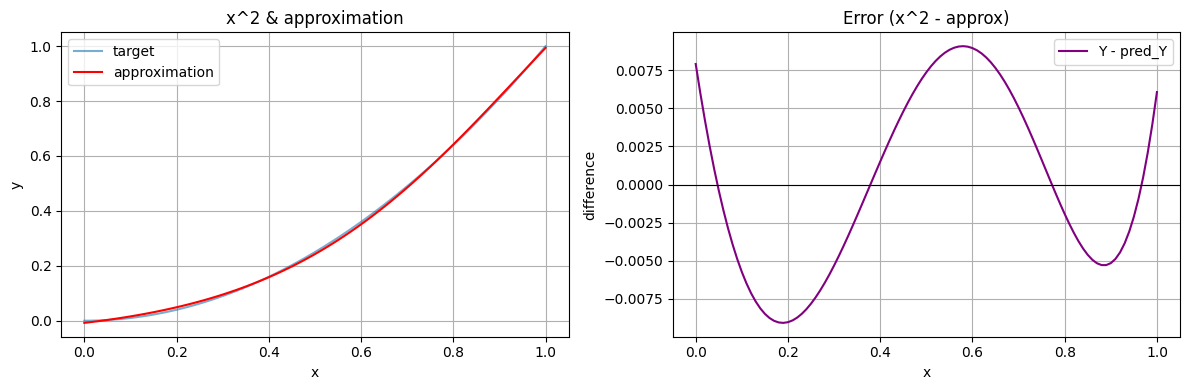

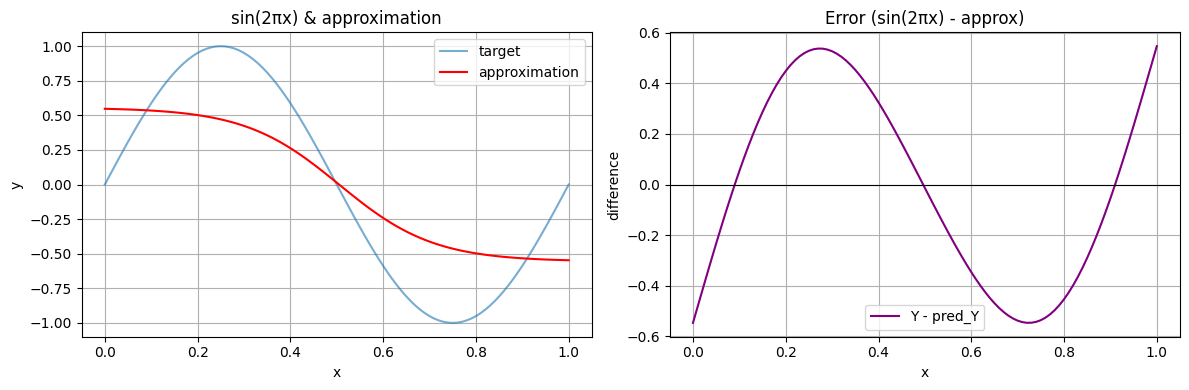

In [9]:
plot_approximation("x^2", train_X, train_Y0, pred_Y0)
plot_approximation("sin(2πx)", train_X, train_Y1, pred_Y1)

**Subgradient Method**

Derivatives at a single sample $x$ with $u_j = \beta_j x + c_j$ and $\sigma'(u_j) = \sigma(u_j)(1-\sigma(u_j))$:
- $\partial g/\partial c_0 = 1$
- $\partial g/\partial \alpha_j = \sigma(u_j)$
- $\partial g/\partial \beta_j = \alpha_j\,\sigma'(u_j)\,x$
- $\partial g/\partial c_j = \alpha_j\,\sigma'(u_j)$



In [10]:
def gn_grad(x: float, cs: np.ndarray, alphas: np.ndarray, betas: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Gradient of g_n(x; cs, alphas, betas) w.r.t. parameters at a single point x.

    g_n(x) = c_0 + sum_{i=1..n} alpha_i * sigmoid(beta_i * x + c_i),
    where cs = [c_0, c_1, ..., c_n].

    Returns a dict with same-shaped arrays:
      - grad['cs']     has shape (n+1,) corresponding to (c_0, c_1, ..., c_n)
      - grad['alphas'] has shape (n,)
      - grad['betas']  has shape (n,)
    """
    cs = np.asarray(cs, dtype=float).reshape(-1)
    alphas = np.asarray(alphas, dtype=float).reshape(-1)
    betas = np.asarray(betas, dtype=float).reshape(-1)

    n = int(alphas.size)

    if betas.size != n:
        raise ValueError(f"Shape mismatch: betas.size={betas.size} != n={n}")
    if cs.size != n + 1:
        raise ValueError(f"Shape mismatch: cs.size={cs.size} != n+1={n+1}")

    c = cs[1:]                       # (n,)
    u = betas * float(x) + c         # (n,)
    s = sigmoid(u)                   # (n,)
    sp = s * (1.0 - s)               # (n,)
    grad_cs = np.empty_like(cs)
    grad_cs[0] = 1.0
    grad_cs[1:] = alphas * sp
    grad_alphas = s
    grad_betas = alphas * sp * x

    return {
        'cs': grad_cs,
        'alphas': grad_alphas,
        'betas': grad_betas,
    }

We want to minimize $\|e(\theta)\|_\infty = \max_i |e_i(\theta)|$ for $e_i(\theta) := g(x_i;\theta) - y_i$

In order to do it, we would apply method similar to gradient descent, but only for one term:
- we pick $k = \arg\max_i |e_i(\theta)|$ 
- we step against $\nabla_\theta |e_k(\theta)| = \operatorname{sign}(e_k)\, \nabla_\theta g(x_k;\theta)$

In [11]:
def get_theta(n: int) -> Dict[str, np.ndarray]:
    return {
        'cs': np.linspace(-1.0, 1.0, n + 1),
        'alphas': np.linspace(-1.0, 1.0, n),
        'betas': np.linspace(-1.0, 1.0, n),
    }

In [12]:
def linf_subgradient_descent(
    X: np.ndarray,
    Y: np.ndarray,
    iterations: int,
    lr: float,
    n: int = 1,
 ) -> Tuple[Dict[str, np.ndarray], np.ndarray]:
    """
    L_inf subgradient method for minimizing max_i |g(X_i; theta) - Y_i|.

    Starts from theta = get_theta(n). Each iteration:
      - k = argmax_i |e_i| where e_i = g(X_i) - Y_i
      - theta <- theta - lr * sign(e_k) * grad g(X_k)

    Returns: (theta, errors) where errors[t] = max_i |e_i| at iteration t.
    """
    X = np.asarray(X, dtype=float).reshape(-1)
    Y = np.asarray(Y, dtype=float).reshape(-1)
    if X.shape != Y.shape:
        raise ValueError(f"X.shape={X.shape} != Y.shape={Y.shape}")
    if iterations <= 0:
        raise ValueError("N must be positive")
    if lr <= 0.0:
        raise ValueError("lr must be positive")

    theta = get_theta(n)
    errors = np.empty(iterations, dtype=float)

    for t in range(iterations):
        preds = gn(X, theta['cs'], theta['alphas'], theta['betas'])
        e = preds - Y
        k = int(np.argmax(np.abs(e)))
        sgn = 1.0 if e[k] >= 0.0 else -1.0

        grad = gn_grad(float(X[k]), theta['cs'], theta['alphas'], theta['betas'])
        theta['cs'] = theta['cs'] - lr * sgn * grad['cs']
        theta['alphas'] = theta['alphas'] - lr * sgn * grad['alphas']
        theta['betas'] = theta['betas'] - lr * sgn * grad['betas']

        errors[t] = float(np.max(np.abs(e)))

    return theta, errors

In [13]:
sg_n1_f0, err_n1_f0 = linf_subgradient_descent(train_X, train_Y0, iterations=20000, lr=0.01)
print(f" error: {err_n1_f0[-1]} theta: {sg_n1_f0}")
pred_n1_f0_Y = gn(train_X, sg_n1_f0['cs'], sg_n1_f0['alphas'], sg_n1_f0['betas'])

 error: 0.01526272201895476 theta: {'cs': array([2.14      , 3.54413627]), 'alphas': array([-2.22592025]), 'betas': array([-3.48789907])}


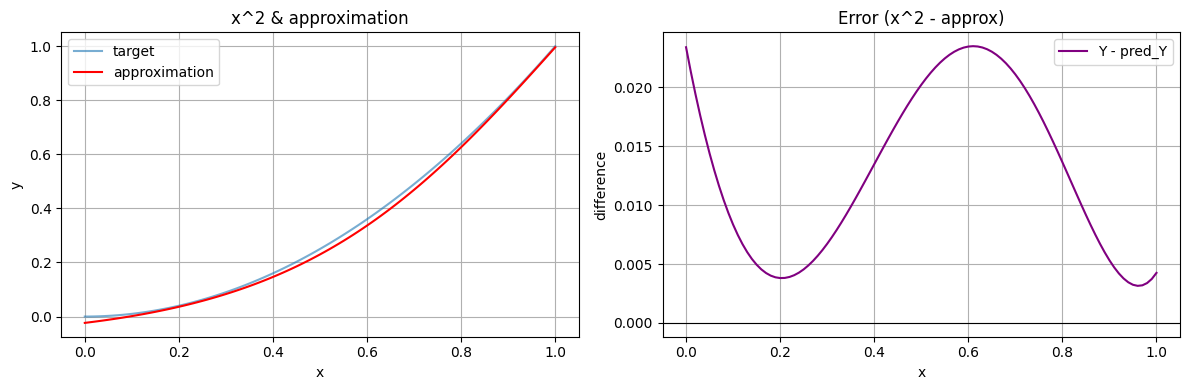

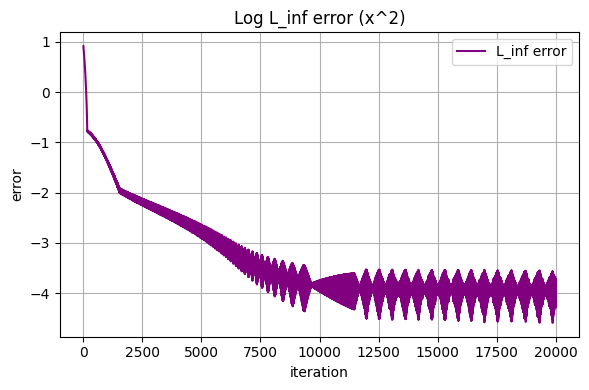

In [14]:
plot_approximation("x^2", train_X, train_Y0, pred_n1_f0_Y)
plot_error("x^2", err_n1_f0, log=True)

In [15]:
sg_n1_f1, err_n1_f1 = linf_subgradient_descent(train_X, train_Y1, iterations=20000, lr=0.01)
print(f" error: {err_n1_f1[-1]} theta: {sg_n1_f1}")
pred_n1_f1_Y = gn(train_X, sg_n1_f1['cs'], sg_n1_f1['alphas'], sg_n1_f1['betas'])

 error: 0.6313551795714543 theta: {'cs': array([-0.78      ,  2.20395602]), 'alphas': array([1.57542188]), 'betas': array([-4.38986339])}


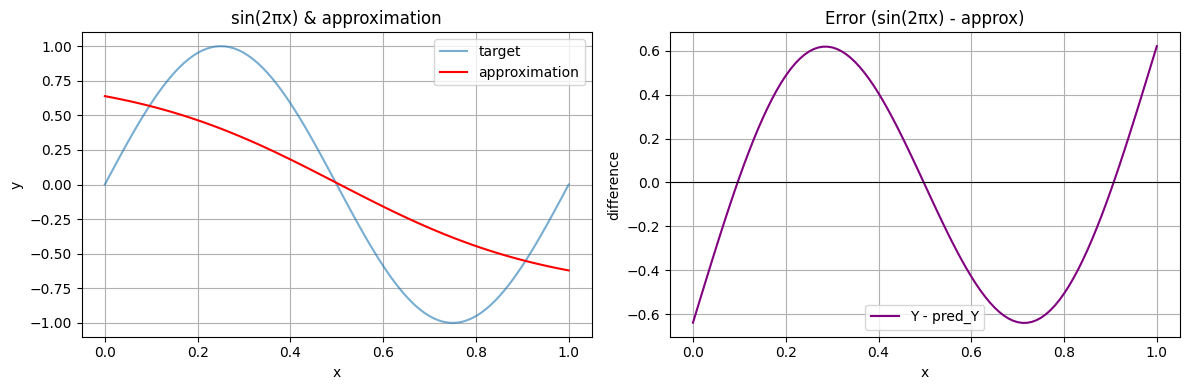

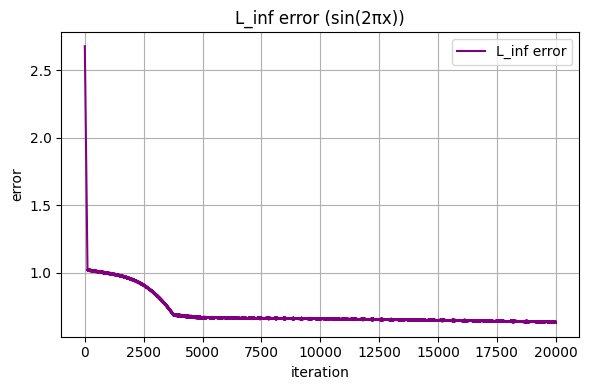

In [16]:
plot_approximation("sin(2πx)", train_X, train_Y1, pred_n1_f1_Y)
plot_error("sin(2πx)", err_n1_f1)

**Now we try experiment with $n=2$**

In [17]:
sg_n2_f0, err_n2_f0 = linf_subgradient_descent(train_X, train_Y0, iterations=300000, lr=0.0025, n=2)
print(f"error: {err_n2_f0[-1]} theta: {sg_n2_f0}")
pred_n2_f0_Y = gn(train_X, sg_n2_f0['cs'], sg_n2_f0['alphas'], sg_n2_f0['betas'])

error: 0.005812026332385964 theta: {'cs': array([1.1       , 2.92761996, 0.55275686]), 'alphas': array([-2.99838072,  2.73295758]), 'betas': array([-2.86275948, -0.44748648])}


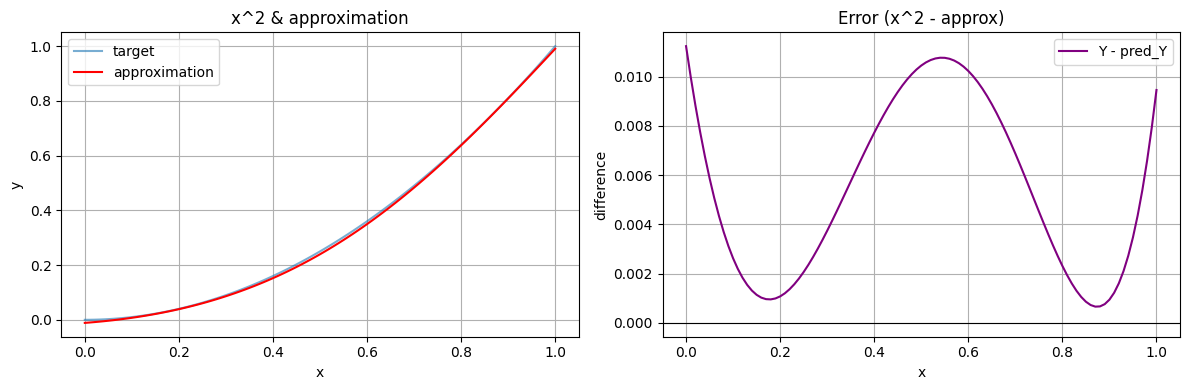

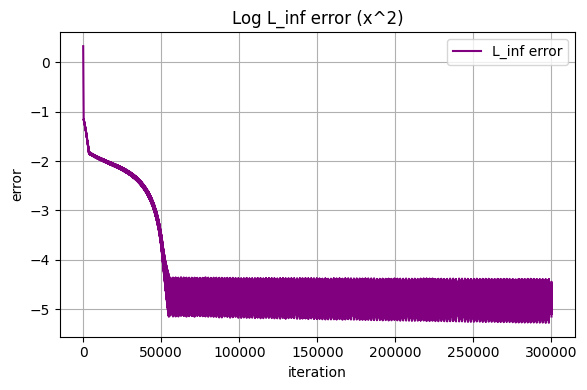

In [18]:
plot_approximation("x^2", train_X, train_Y0, pred_n2_f0_Y)
plot_error("x^2", err_n2_f0, log=True)

In [19]:
sg_n2_f1, err_n2_f1 = linf_subgradient_descent(train_X, train_Y1, iterations=300000, lr=0.005, n=2)
print(f"error: {err_n2_f1[-1]} theta: {sg_n2_f1}")
pred_n2_f1_Y = gn(train_X, sg_n2_f1['cs'], sg_n2_f1['alphas'], sg_n2_f1['betas'])

error: 0.12419274127563429 theta: {'cs': array([-8.63      ,  4.54818423, -1.29780548]), 'alphas': array([ 6.50433682, 10.83433769]), 'betas': array([-9.0815103 ,  2.57507087])}


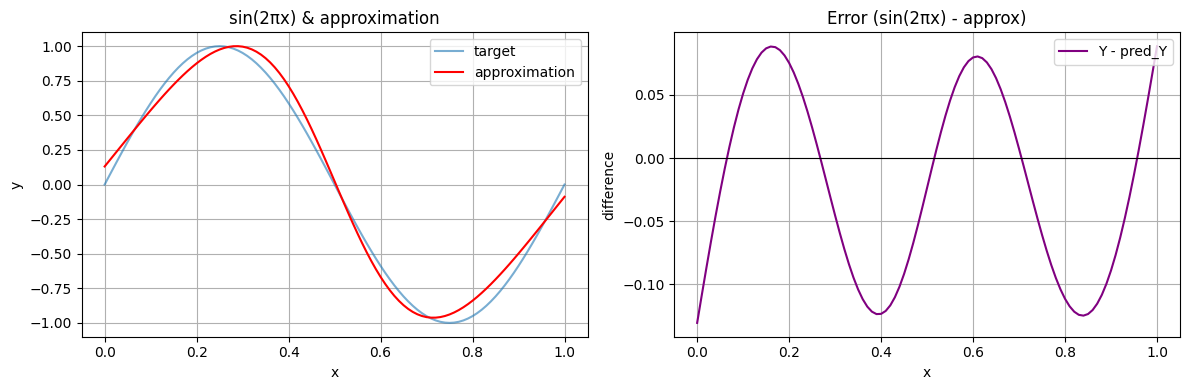

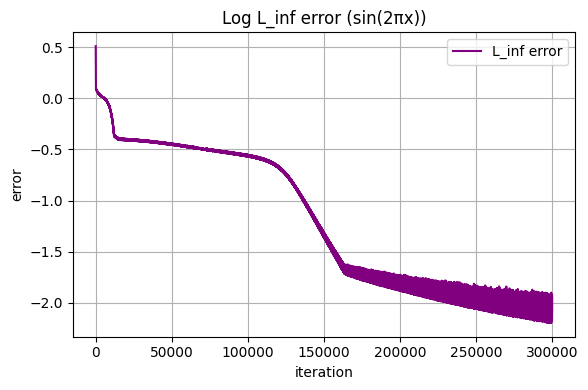

In [20]:
plot_approximation("sin(2πx)", train_X, train_Y1, pred_n2_f1_Y)
plot_error("sin(2πx)", err_n2_f1, log=True)